In [1]:
# Step 1: Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import os



In [3]:
# Step 2: Paths
dataset_dir = "PlantVillage"  # <-- Change if needed
image_size = 128
batch_size = 32
EPOCHS = 20



In [5]:
# Step 3: Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)



Found 7981 images belonging to 15 classes.
Found 1990 images belonging to 15 classes.


In [6]:
# Step 4: Build Model (Transfer Learning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



In [7]:
# Step 5: Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 6: Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]



In [8]:
# Step 7: Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Step 8: Save final model
model.save("final_crop_disease_model.keras")


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4728 - loss: 1.7264

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.78241, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 401ms/step - accuracy: 0.4734 - loss: 1.7243 - val_accuracy: 0.7824 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7745 - loss: 0.6847
Epoch 2: val_accuracy improved from 0.78241 to 0.82764, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 344ms/step - accuracy: 0.7746 - loss: 0.6846 - val_accuracy: 0.8276 - val_loss: 0.5205 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8079 - loss: 0.5877
Epoch 3: val_accuracy improved from 0.82764 to 0.84221, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 307ms/step - accuracy: 0.8080 - loss: 0.5876 - val_accuracy: 0.8422 - val_loss: 0.4853 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8338 - loss: 0.5050
Epoch 4: val_accuracy improved from 0.

In [9]:
model.save("multi_crop_disease_model.keras")  # Required .keras format in Keras 3+


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 286ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.95      0.92      0.94       165
                     Pepper__bell___healthy       0.97      0.98      0.97       295
                      Potato___Early_blight       0.91      1.00      0.95       144
                       Potato___Late_blight       0.92      0.89      0.90        85
                           Potato___healthy       0.91      0.88      0.89        24
                      Tomato_Bacterial_spot       0.87      0.91      0.89       163
                        Tomato_Early_blight       0.64      0.58      0.61        74
                         Tomato_Late_blight       0.86      0.80      0.83       158
                           Tomato_Leaf_Mold       0.81      0.85      0.83        86
                  Tomato_Septoria_leaf_spot       0.77      0.77      0.77       141
Tomato_Spider_mites_Tw

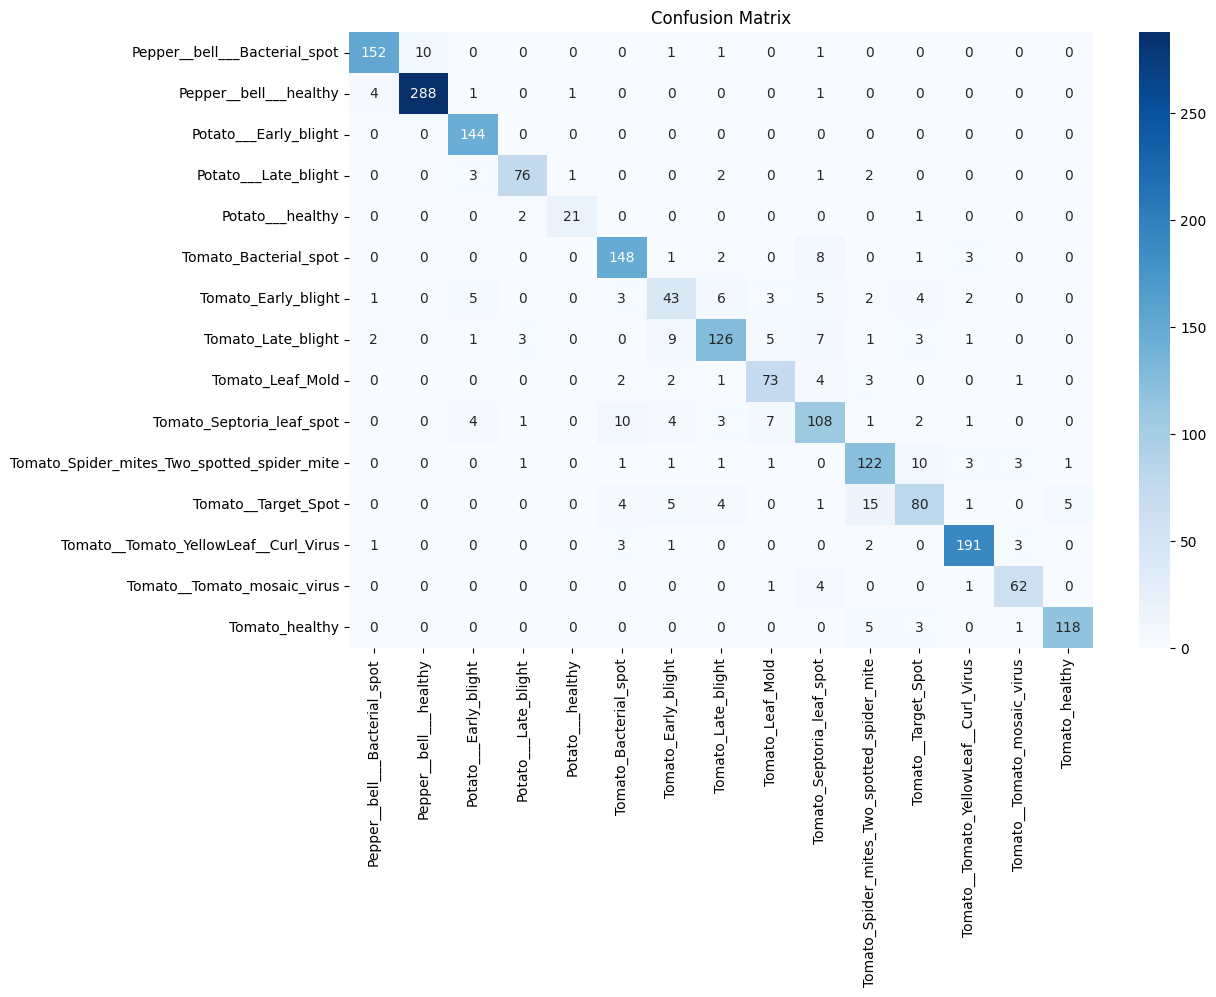

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict all validation data
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

# Class labels
class_labels = list(val_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
